In [18]:
import pandas as pd
import numpy as np
import pymc as pm
from src.data_utils import load_and_process_data
from src.model_v2 import build_and_sample_dynamic_model
from src.trace_save_load import load_previous_season_trace, extract_previous_season_priors
#import matplotlib.pyplot as plt

league = ['Premier_League']
match_date = '2023-08-01'


# Simple one-liner to get everything ready
df, team_mapping, n_teams = load_and_process_data(
    db_path=r'C:\Users\Owner\dev\algobetting\infra\data\db\fotmob.db',
    league=league, 
    #season=season,
    match_date=match_date,
    max_goals=9,
    decay_rate=0.002,
    goals_weight=0.5,
    xg_weight=0.5,
    psxg_weight=0.3

)

df['period'] = df['match_date'].rank(method="dense").astype(int) - 1
n_periods = df['period'].max() + 1


In [19]:
model, idata = build_and_sample_dynamic_model(
    df,
    n_teams=n_teams,
    n_periods=n_periods,
    draws=1000,
    tune=500,
)


c:\Users\Owner\AppData\Local\Programs\Python\Python312\Lib\site-packages\pymc\data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
home_adv  0.17  0.04    0.09     0.24        0.0      0.0   1001.37   2108.21   
baseline  0.21  0.05    0.12     0.29        0.0      0.0    803.07   1115.96   

          r_hat  
home_adv   1.00  
baseline   1.01  


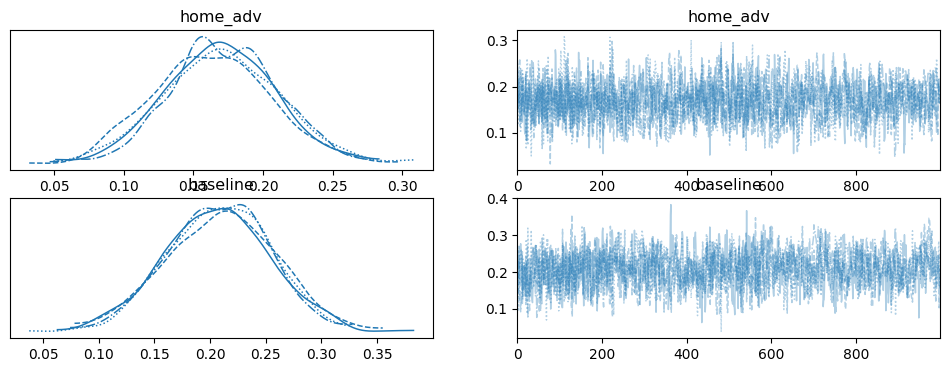

In [27]:
import arviz as az

# Summarize key parameters
print(az.summary(idata, var_names=["home_adv", "baseline"], round_to=2))

# Plot sampling diagnostics
az.plot_trace(idata, var_names=["home_adv", "baseline"]);


In [28]:
# Extract the raw parameters from posterior
att_init = idata.posterior["att_init"].values  # Shape: (chain, draw, n_teams)
def_init = idata.posterior["def_init"].values  # Shape: (chain, draw, n_teams)
att_incr = idata.posterior["att_incr"].values  # Shape: (chain, draw, n_teams, n_periods-1)
def_incr = idata.posterior["def_incr"].values  # Shape: (chain, draw, n_teams, n_periods-1)

# Get dimensions
n_chains, n_draws, n_teams, n_periods_minus_1 = att_incr.shape
n_periods = n_periods_minus_1 + 1

# Reconstruct the full time series
att_full = np.zeros((n_chains, n_draws, n_teams, n_periods))
def_full = np.zeros((n_chains, n_draws, n_teams, n_periods))

# First period is the initial values
att_full[:, :, :, 0] = att_init
def_full[:, :, :, 0] = def_init

# Subsequent periods are cumulative sums of increments
att_full[:, :, :, 1:] = att_init[:, :, :, np.newaxis] + np.cumsum(att_incr, axis=3)
def_full[:, :, :, 1:] = def_init[:, :, :, np.newaxis] + np.cumsum(def_incr, axis=3)

# Apply centering (as done in the model)
att_centered = att_full - np.mean(att_full, axis=2, keepdims=True)
def_centered = def_full - np.mean(def_full, axis=2, keepdims=True)

# Get posterior means (average over chains and draws)
att_means = att_centered.mean(axis=(0, 1))  # Shape: (n_teams, n_periods)
def_means = def_centered.mean(axis=(0, 1))  # Shape: (n_teams, n_periods)

# Transpose to match your expected shape (n_periods, n_teams)
att_means = att_means.T  # Shape: (n_periods, n_teams)
def_means = def_means.T  # Shape: (n_periods, n_teams)

print(att_means.shape)  # (n_periods, n_teams)

(243, 25)


In [29]:
import pandas as pd

team_idx_to_name = {idx: team for team, idx in team_mapping.items()}

# Example: build tidy dataframe
records = []
for p in range(att_means.shape[0]):
    for t in range(att_means.shape[1]):
        records.append({
            "period": p,
            "team": team_idx_to_name[t],
            "attack": att_means[p, t],
            "defense": def_means[p, t]
        })

ratings_df = pd.DataFrame(records)


In [30]:
ratings_df["team"].unique()

array(['Arsenal', 'Aston Villa', 'Bournemouth', 'Brentford', 'Brighton',
       'Burnley', 'Chelsea', 'Crystal Palace', 'Everton', 'Fulham',
       'Ipswich', 'Leeds', 'Leicester', 'Liverpool', 'Luton Town',
       'Man City', 'Man United', 'Newcastle', 'Nottm Forest', 'Sheff Utd',
       'Southampton', 'Sunderland', 'Tottenham', 'West Ham', 'Wolves'],
      dtype=object)

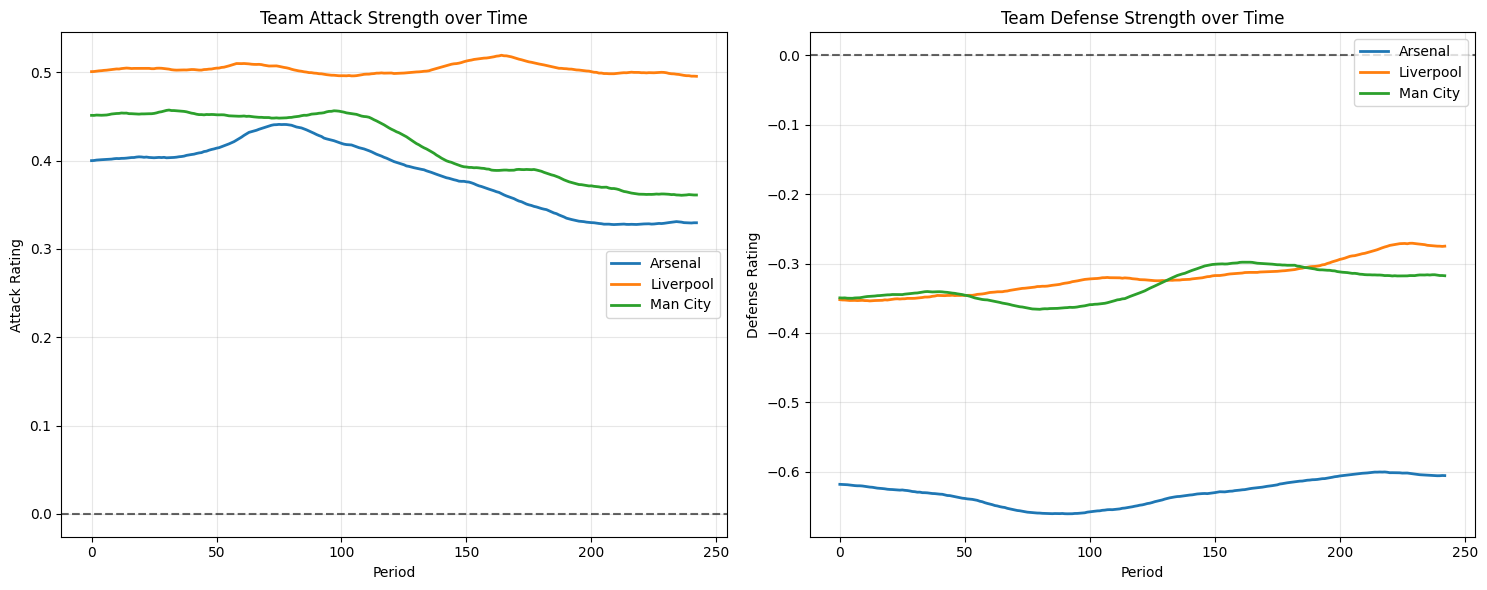

In [34]:
import matplotlib.pyplot as plt

clubs = ["Arsenal", "Liverpool", "Man City"]

# Create subplots - 1 row, 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Attack strength plot
for club in clubs:
    subset = ratings_df[ratings_df["team"] == club]
    ax1.plot(subset["period"], subset["attack"], label=club, linewidth=2)

ax1.axhline(0, color="black", linestyle="--", alpha=0.6)
ax1.legend()
ax1.set_title("Team Attack Strength over Time")
ax1.set_xlabel("Period")
ax1.set_ylabel("Attack Rating")
ax1.grid(True, alpha=0.3)

# Defense strength plot
for club in clubs:
    subset = ratings_df[ratings_df["team"] == club]
    ax2.plot(subset["period"], subset["defense"], label=club, linewidth=2)

ax2.axhline(0, color="black", linestyle="--", alpha=0.6)
ax2.legend()
ax2.set_title("Team Defense Strength over Time")
ax2.set_xlabel("Period")
ax2.set_ylabel("Defense Rating")
ax2.grid(True, alpha=0.3)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()